In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter
import pandas as pd

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [23]:
btc_usd = pd.read_csv("Documents/disserationreference/gemini_BTCUSD_1hr.csv", parse_dates=["Date"])
btc_usd.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1619049600000,2021-04-22 00:00:00,BTCUSD,53804.03,54104.26,53633.30,53853.52,10.712695
1,1619046000000,2021-04-21 23:00:00,BTCUSD,54027.38,54377.24,53599.41,53804.03,122.252890
2,1619042400000,2021-04-21 22:00:00,BTCUSD,54793.66,55073.65,53800.00,54027.38,101.185655
3,1619038800000,2021-04-21 21:00:00,BTCUSD,54998.52,55320.25,54714.28,54793.66,52.445867
4,1619035200000,2021-04-21 20:00:00,BTCUSD,55493.13,55525.74,54835.87,54998.52,116.188554


In [24]:
btc_usd = btc_usd.dropna()
btc_usd = btc_usd[btc_usd.Volume > 2.0]
btc_usd = btc_usd.iloc[::-1]
btc_usd = btc_usd.reset_index(drop=True)
btc_usd.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1444312800,2015-10-08 14:00:00,BTCUSD,245.00,245.00,244.50,245.00,4.453649
1,1444316400,2015-10-08 15:00:00,BTCUSD,245.00,245.00,244.92,244.92,3.016926
2,1444320000,2015-10-08 16:00:00,BTCUSD,244.92,244.92,244.25,244.25,3.895252
3,1444323600,2015-10-08 17:00:00,BTCUSD,244.25,244.99,244.02,244.99,3.920632
4,1444327200,2015-10-08 18:00:00,BTCUSD,244.99,244.99,244.00,244.00,3.690472


In [25]:
btc_usd["Returns"] = btc_usd["Close"].pct_change()
btc_rr = btc_usd["Returns"]

In [5]:
btc_real_y = np.power(((btc_rr.iloc[1:]).iloc[::5,]).iloc[1:], 2)
btc_real_y = btc_real_y.reset_index(drop=True)
btc_real_y.iloc[:10]

0    0.000000
1    0.000586
2    0.000010
3    0.000009
4    0.000000
5    0.000042
6    0.000012
7    0.000001
8    0.000006
9    0.000062
Name: Returns, dtype: float64

In [28]:
btc_usd["logR"] = np.log(1 + btc_usd.Returns)
#btc_usd["logaR"] = np.log(1 + np.abs(btc_usd.Returns))
#btc_usd["logR2"] = np.log(1 + np.power(btc_usd.Returns, 2))
btc_usd["logR+"] = np.where(btc_usd["logR"]>=0, btc_usd["logR"], 0)
btc_usd["logR-"] = np.where(btc_usd["logR"]<0, -1.0*btc_usd["logR"], 0)

btc_usd["logR+"] = np.power(btc_usd["logR+"],2)
btc_usd["logR-"] = np.power(btc_usd["logR-"],2)


btc_usd_rets = btc_usd[['logR', 'logR+', 'logR-']].iloc[1:]
btc_usd_rets = (btc_usd_rets.rolling(7).mean())
btc_usd_rets['Unix Timestamp'] = btc_usd['Unix Timestamp']
btc_usd_rets = btc_usd_rets.iloc[::7,:]
#btc_usd_vol["V+"] = btc_usd_rets.rolling(5).mean()['logR+']
#btc_usd_vol["V-"] = btc_usd_rets.rolling(5).mean()['logR-']
#btc_usd_vol["V"] = btc_usd_rets.rolling(5).mean()['logR']
#btc_usd_vol = (df.iloc[::5,:].copy())
btc_usd_rets['logR']=(btc_usd_rets['logR']-btc_usd_rets['logR'].mean())/btc_usd_rets['logR'].std()
btc_usd_rets['logR+']=(btc_usd_rets['logR+']-btc_usd_rets['logR+'].mean())/btc_usd_rets['logR+'].std()
btc_usd_rets['logR-']=(btc_usd_rets['logR-']-btc_usd_rets['logR-'].mean())/btc_usd_rets['logR-'].std()
btc_usd_rets = btc_usd_rets.reset_index(drop=True)

In [20]:
btc_usd_rets['X'] = (btc_usd_rets['Unix Timestamp']-btc_usd_rets['Unix Timestamp'].iloc[0])/(1000)
btc_usd_rets = btc_usd_rets.iloc[1:]
np.shape(btc_usd_rets)

(1891, 5)

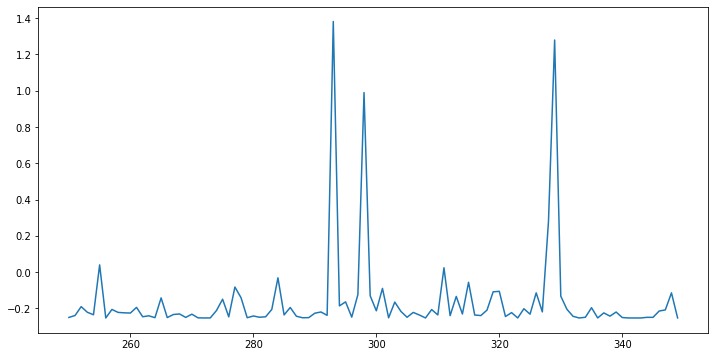

In [30]:
plt.plot(btc_usd_rets["logR-"].iloc[250:350])

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.0738689 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 20.9919    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64

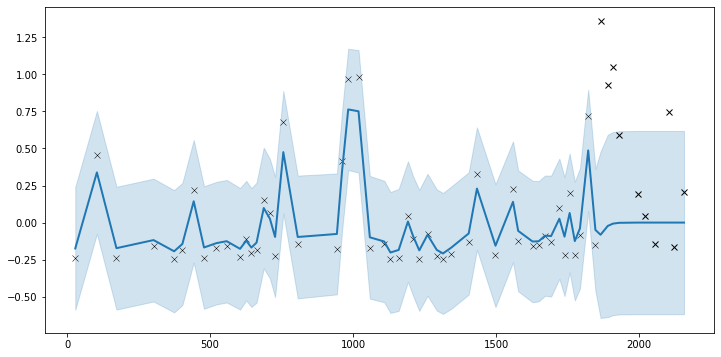

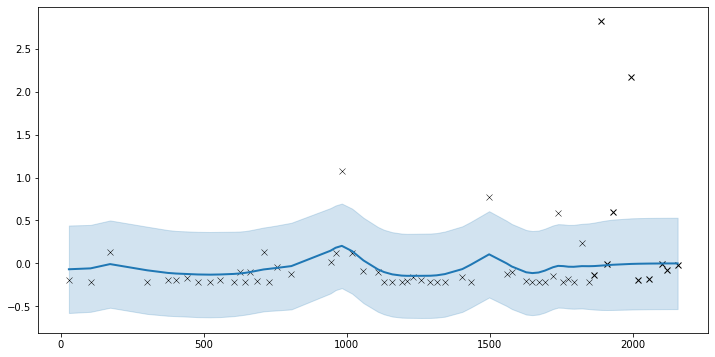

In [9]:
N = np.shape(btc_usd_rets)[0]
window = 50
delta = 10
errors = []

X = ((btc_usd_rets['X'].iloc[:window]).values).reshape(-1,1)
Xtest = ((btc_usd_rets['X'].iloc[:window+delta]).values).reshape(-1,1)

Yp = ((btc_usd_rets['logR+'].iloc[:window]).values).reshape(-1,1)
Yn = ((btc_usd_rets['logR-'].iloc[:window]).values).reshape(-1,1)

kp = gpflow.kernels.Matern32(variance=2, lengthscales=5)+gpflow.kernels.White(variance=0.5**2)
kn = gpflow.kernels.Matern32(variance=2, lengthscales=5)+gpflow.kernels.White(variance=0.5**2)
mp = gpflow.models.GPR(data=(X, Yp), kernel=kp)
mn = gpflow.models.GPR(data=(X, Yn), kernel=kn)

maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(
    mp.training_loss, mp.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(
    mn.training_loss, mn.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)



mu_p, cov_p = mp.predict_f(Xtest)
mu_n, cov_n = mn.predict_f(Xtest)


error_p = (np.exp(mu_p[window:window+delta]) + np.exp(mu_n[window:window+delta]) - 2)/2 - ((btc_real_y.iloc[window:window+delta]).values).reshape(-1,1)

print_summary(mp)
print_summary(mn)

plt.figure(figsize=(12, 6))
plt.plot(X, Yp, "kx", mew=0.5)
plt.plot(Xtest[50:60], ((btc_usd_rets['logR+'].iloc[50:60]).values).reshape(-1,1), "kx")
plt.plot(Xtest, mu_p, "C0", lw=2)
plt.fill_between(
    Xtest[:, 0],
    (mu_p[:, 0] - 1.96 * np.sqrt(cov_p[:, 0])),
    (mu_p[:, 0] + 1.96 * np.sqrt(cov_p[:, 0])),
    color="C0",
    alpha=0.2,
)

plt.figure(figsize=(12, 6))
plt.plot(X, Yn, "kx", mew=0.5)
plt.plot(Xtest[50:60], ((btc_usd_rets['logR-'].iloc[50:60]).values).reshape(-1,1), "kx")
plt.plot(Xtest, (mu_n), "C0", lw=2)
plt.fill_between(
    Xtest[:, 0],
    mu_n[:, 0] - 1.96 * np.sqrt(cov_n[:, 0]),
    mu_n[:, 0] + 1.96 * np.sqrt(cov_n[:, 0]),
    color="C0",
    alpha=0.2,
)

print(error_p)

In [10]:
N = np.shape(btc_usd_rets)[0]
window = 70
delta = 7
errors = []
for i in range(N-window):
    # Get the positve and negative volatilities for the window 
    X = ((rets['X'].iloc[i:i+window]).values).reshape(-1,1)
    Xtest = ((rets['X'].iloc[i:i+window+delta]).values).reshape(-1,1) 
    Yp = ((rets['logR+'].iloc[i:i+window]).values).reshape(-1,1)
    Yn = ((rets['logR-'].iloc[i:i+window]).values).reshape(-1,1)
    # Set up the kernels with the previous windows parameters
    kp = gpflow.kernels.Matern32(variance=mp.kernel.kernels[0].variance, 
                        lengthscales=mp.kernel.kernels[0].lengthscales)
         +gpflow.kernels.White(variance=mp.kernel.kernels[1].variance)
        
    kn = gpflow.kernels.Matern32(variance=mn.kernel.kernels[0].variance,
                        lengthscales=mn.kernel.kernels[0].lengthscales)
        +gpflow.kernels.White(variance=mn.kernel.kernels[1].variance)
    # Set up the models
    mp = gpflow.models.GPR(data=(X, Yp), kernel=kp)
    mn = gpflow.models.GPR(data=(X, Yn), kernel=kn)
    # Optimise hyperparameters every 10 windows regardless
    if(i%10):
        maxiter = ci_niter(10000)
        gpflow.optimizers.Scipy().minimize(
            mp.training_loss, mp.trainable_variables, 
            options=dict(maxiter=maxiter), method="L-BFGS-B",
        )

        maxiter = ci_niter(10000)
        gpflow.optimizers.Scipy().minimize(
            mn.training_loss, mn.trainable_variables, 
            options=dict(maxiter=maxiter), method="L-BFGS-B",
        )
    # Make forecasts
    mu_p, cov_p = mp.predict_f(Xtest)
    mu_n, cov_n = mn.predict_f(Xtest)
    # reconstruct returns from positive and negative
    r_bar = (np.exp(mu_p[window:window+delta]) + np.exp(mu_n[window:window+delta]) - 2.0)/2.0
    # real values of volatility to compare with
    realised_vol = ((real.iloc[i+window:i+window+delta]).values).reshape(-1,1)
    error_p = np.abs(r_bar - realised_vol)
    # save values for inspection
    errors.append((i, error_p[0], kp, kn))
    

0 [0.05492883]
1 [0.11274814]
2 [0.37692807]
3 [0.45840262]
4 [0.18820089]
5 [0.74718896]
6 [0.19545537]
7 [0.03447259]
8 [0.2126893]
9 [0.04443831]
10 [0.0553129]
11 [0.14479801]
12 [0.16269812]
13 [0.10318374]
14 [0.54253178]
15 [1.6466277]
16 [0.58025499]
17 [1.35582753]
18 [2.91046214]
19 [5.14180898]
20 [1.31208546]
21 [7.26119469]
22 [38.35897101]
23 [10.68253717]


InvalidArgumentError:  Input matrix is not invertible.
	 [[node triangular_solve/MatrixTriangularSolve (defined at /home/cdtmc/.local/lib/python3.8/site-packages/gpflow/logdensities.py:97) ]] [Op:__inference__tf_eval_57230]

Errors may have originated from an input operation.
Input Source operations connected to node triangular_solve/MatrixTriangularSolve:
 sub (defined at /home/cdtmc/.local/lib/python3.8/site-packages/gpflow/logdensities.py:96)	
 Cholesky (defined at /home/cdtmc/.local/lib/python3.8/site-packages/gpflow/models/gpr.py:87)

Function call stack:
_tf_eval


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(X, Yp, "kx", mew=0.5)
plt.plot(Xtest[50:60], Y_actual, "kx")
plt.plot(Xtest, mu_p, "C0", lw=2)
plt.fill_between(
    Xtest[:, 0],
    (mu_p[:, 0] - 1.96 * np.sqrt(cov_p[:, 0])),
    (mu_p[:, 0] + 1.96 * np.sqrt(cov_p[:, 0])),
    color="C0",
    alpha=0.2,
)

plt.figure(figsize=(12, 6))
plt.plot(X, Yn, "kx", mew=0.5)
plt.plot(Xtest[50:60], Y_actual, "kx")
plt.plot(Xtest, mu_n, "C0", lw=2)
plt.fill_between(
    Xtest[:, 0],
    (mu_n[:, 0] - 1.96 * np.sqrt(cov_n[:, 0])),
    (mu_n[:, 0] + 1.96 * np.sqrt(cov_n[:, 0])),
    color="C0",
    alpha=0.2,
)
print(error_p)

In [ ]:
errors

In [ ]:
index = btc_usd_rets.index
start_loc = 0
end_loc = np.where(index >= '2020-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T